### Assignment: Learning the Thermodynamics of Liquid Hafnium

#### Allen (Yixin) Hu

loading in the required packages...

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from corner import corner
import pandas as pd
import numpy as np
import kombine

Loading the data...

In [2]:
h_data = pd.read_csv('data/Cag2008.csv', delim_whitespace=True)
cp_data = pd.read_csv('data/Kor2005.csv', delim_whitespace=True)

In [3]:
cp_data.head()

,T,Cp,sigma_Cp,phase
0,2572.576997,43.436111,0.664185,liquid
1,2771.501011,43.826980,0.581517,liquid
2,2970.600775,44.591934,0.290242,liquid
3,3170.188737,46.396015,0.498180,liquid
4,3369.210390,46.994709,0.581219,liquid


# Problem 1: Building Prior Distributions

We will try to fit a model that expresses the heat capacity as a linear model:

$C_p(T) = c_1 + c_2 T$ (1.1)

Thermodyanmics dictates that enthalpy is defined by:

$H(T) = \int_0^T C_p(T) dT = c_0 + c_1 T + c_2 T^2/2$ (1.2)

Note that the thermodynamic model has three parameters $c_0$, $c_1$ and $c_2$.

First step is to define a prior distribution via a simple robust regression to find an estimate for c_1 and c_2 using the expression (1.1) above and the cp_data dataframe.

In [4]:
x = cp_data['T']
y = cp_data['Cp']

robust_reg1 = stats.siegelslopes(y,x)

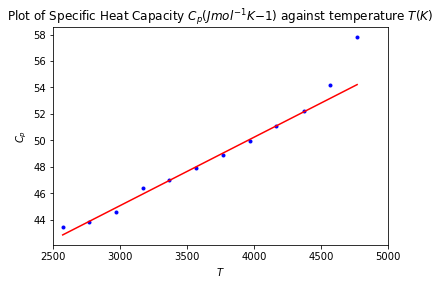

In [5]:
fig, ax = plt.subplots()
ax.plot(x, y, 'b.')
ax.set_xlim(2500, 5000)
ax.plot(x, robust_reg1[1] + robust_reg1[0] * x, 'r-')
plt.xlabel("$T$")
plt.ylabel("$C_p$")
plt.title("Plot of Specific Heat Capacity $C_p (J mol^{-1}K{-1})$ against temperature $T (K)$")
plt.show()

Next, we have to compute $c_0$ by rearranging (1.2) and using this method on the h_data dataset:

$H(T) = c_0 + c_1 T + c_2 T^2/2$
$\rightarrow H(T) - c_1 T - c_2 T^2/2 = c_0 $

In [6]:
c_1 = robust_reg1[1]
c_2 = robust_reg1[0]
resid = h_data['H'] - c_1 * h_data['T'] - c_2 * h_data['T'] ** 2 / 2

In [7]:
resid

0     3314.960105
1     3464.797728
2     4095.936126
3     4495.037316
4     4775.066037
5     5181.028646
6     5165.530078
7     5280.618276
8     5268.620096
9     5402.973945
10    5370.901506
11    5393.157559
12    5401.698029
13    5388.712190
14    5328.215683
15    5327.561181
16    5238.713535
17    5093.844177
18    5018.494062
dtype: float64

Computing the median of residual to estimate $c_0$...

In [8]:
c_0 = np.median(resid)
print(c_0) 

5238.713535338946


Making a plot of enthalpy $H$ against temperature $T$. Show both the data points and the fitted curve.

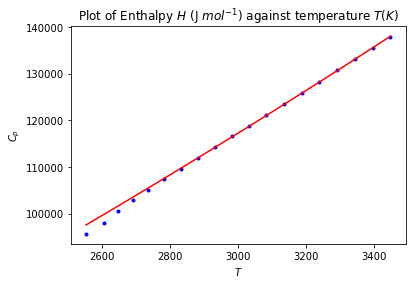

In [9]:
x_2 = h_data['T']
y_2 = h_data['H']

fig, ax = plt.subplots()
ax.plot(x_2, y_2, 'b.')
ax.plot(x_2, c_0 +  c_1 * h_data['T'] + c_2 * h_data['T'] ** 2 / 2, 'r-')
plt.xlabel("$T$")
plt.ylabel("$C_p$")
plt.title("Plot of Enthalpy $H$ (J $mol^{-1})$ against temperature $T (K)$")
plt.show()

Constructing prior distributions using scipy's Normal distribution by:
1) setting the location to be the values of the parameters determined by the curve fitting
2) the scale to be 50% of the parameter value.

In [10]:
c_params = [c_0,c_1,c_2]
priors = []

for param in c_params:
    priors.append(stats.norm(param, 0.5 * abs(param))) 
    #abs is to make sure that negative values dont get negative variance
    
#rmse = np.sqrt(np.power(c_0 +  c_1 * h_data['T'] + c_2 * h_data['T'] ** 2 / 2, 2).sum())
#priors.append(stats.expon(scale=rmse))

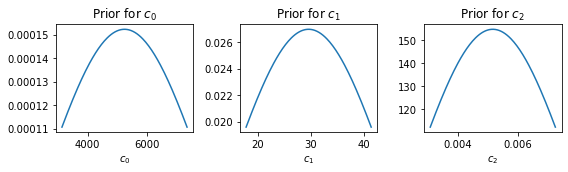

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(8, 2.5))

# Make the distributiosn for each parameter
for ax, prior, m, l in zip(axs, priors, c_params,['$c_0$', '$c_1$', '$c_2$']):
    r = np.linspace(m - 0.4 * abs(m), m + 0.4 * abs(m), 128)
    ax.plot(r, prior.pdf(r))
    
    ax.set_title(f'Prior for {l}')
    ax.set_xlabel(l)
    
#r = np.linspace(1e-6, 0.04, 128)
#ax = axs[-1]
#ax.plot(r, priors[-1].pdf(r))
#ax.set_title(f'Prior for $\\epsilon$')
#ax.set_xlabel('$\\epsilon$')
    
fig.tight_layout()

Calculate the log prior probability of $c_0$ = 5000, $c_1$ = 35, and $c_2$ = 0.005

In [12]:
logpdf = 0
for prior, th in zip(priors,[5000,35,0.0005]):
    logpdf += prior.logpdf(th)

print(logpdf)

-9.064669035861819


#### Defining Prior Distribution for Dataset Hyperparams

Using a uniform prior distribution to define a dataset hyperparameter for the $C_p$ dataset ($\alpha_{C_p}$) and $H$ dataset ($\alpha_H$).

In [13]:
Cp_hyper_prior = stats.uniform(0,10)
H_hyper_prior = stats.uniform(0,10)

dataset_priors = [Cp_hyper_prior,H_hyper_prior]
priors.extend(dataset_priors)
print(len(priors))

5


In [14]:
pdf = 0
for prior, th in zip(dataset_priors,[5,11]):
    pdf += prior.pdf(th)

print(pdf)

0.1


### Problem 2: Defining the Likelihood Function

Now defining a function to compute the posterior probability, given the prior distribution ($P(\theta|M)$) and the likelihood of the observed data ($P(D|\theta,M)$).

That is to say: we want to calculate $P(\theta|D,M) = P(D|\theta,M)P(\theta|M)$

Therefore, we need the second component ($P(D|\theta,M)$), the likelihood of the data, calculated from the following expression:

$P(D_i|\theta,M) = \mathcal{N}(D_i|M(T_i|\theta), \sigma_i/\alpha_D)$

where $\mathcal{N}(x|y,\sigma)$ is the probability distribution function for the normal distribution with mean $y$ and standard deviation $\sigma$. In our context, $\alpha_D$ is the dataset hyperparameter for any one of the datasets, and sigmas are provided from each of the datasets

We assume that the probability of each data point is independent, so you can compute the probability of the whole dataset as:

$P(D|\theta,M) = \prod_i P(D_i|\theta,M) = \sum_i \log P(D_i|\theta,M)$

Using the code provided by our assignment write-up:

In [15]:
class Posterior:
    """Posterior probability of liquid H thermodynamic models
    
    Assumes parameters are in the order: c_0, c_1, c_2, alpha_cp, alpha_h
    """
    
    def __init__(self, cp_data, h_data, priors):
        """Initialize the class
        
        Args:
            cp_data: Heat capacity data
            h_data: Enthalpy data
            prior: Prior distributions for each parameter
        """
        self.cp_data = cp_data
        self.h_data = h_data
        self.priors = priors
        
    def logprob_cp_data(self, params):
        """Compute the log probability of observing the C_p data
        
        Args:
            params ([float]): Chosen parameters
        Returns:
            Log-likelihood of observing the data
        """
        
        # Constructing the normal distributions P(D_i|Theta,M) = N(D_i,S_i/a_D) for each data point
        
        cp_data['preds'] = params[1] + params[2] * cp_data['T']
        
        logpdf = stats.norm(cp_data['preds'], cp_data['sigma_Cp']/params[3]).logpdf(cp_data['Cp']).sum()
    
        return logpdf
    
    def logprob_h_data(self, params):
        """Compute the log probability of observing the H data
        
        Args:
            params ([float]): Chosen parameters
        Returns:
            Log-likelihood of observing the data
        """
        
        h_data['preds'] = params[0] + params[1] * h_data['T'] + params[2] * h_data['T'] ** 2 / 2

        logpdf = stats.norm(h_data['preds'], h_data['sigma_H']/params[4]).logpdf(h_data['H']).sum()

        return logpdf
        
    def logprob_prior(self, params):
        """Compute the log probability of the parameters given the prior distributions.
        
        Includes the prior for model parameters and the "dataset weights" (\alpha)
        
        Args:
            params ([float]): Chosen parameters
        Returns:
            Log-likelihood of the priors
        """
        
        logpdf_prior = 0
        
        for prior, th in zip(priors,params):
            logpdf_prior += prior.logpdf(th)

        return logpdf_prior
    
    def __call__(self, params):
        """Compute the log posterior probability given the paramers
        
        Args:
            params ([float]): Chosen parameters
        Returns:
            Log-likelihood of the posterior
        """
        
        return self.logprob_cp_data(params) + self.logprob_prior(params) + self.logprob_h_data(params)

In [16]:
ln_posterior = Posterior(cp_data, h_data, priors)
test_params = [5000, 35, 0.005, 1, 1]
lnpdf = ln_posterior(test_params)

lnpdf

-1224.5799885607444

### Problem 3 Sampling the Posterior

Sampling 128 points from the prior distribution for each model parameter and storing them in a 128 x 5 array

In [41]:
n_walkers = 128
param_init = np.vstack([
    p.rvs(size=(n_walkers,)) for p in priors
]).T

print(param_init.shape)

(128, 5)


Creating a sampler using Kombine with 128 walkers using the posterior function made previously

In [42]:
n_params = len(priors)

sampler = kombine.Sampler(n_walkers, n_params, ln_posterior, pool=kombine.serialpool.SerialPool())

Burning in the sampler using the initial points sampled from the prior as a starting point.

In [43]:
%%time

output = sampler.burnin(param_init)

CPU times: user 1min 19s, sys: 687 ms, total: 1min 19s
Wall time: 1min 18s


Completing the following tasks:

1. Make a burn-in curve of acceptance probability against steps.
2. How many steps did it take for the sampler to converge? (Please do NOT simply read from the plot. Try to get more accurate statistics out of the sampler objects. Same for next question.)
3. What was the acceptance probability of the last 5 steps? (If it is not ~0.5, re-run the burn in)

Text(0.5, 1.0, 'Burn-in Curve Progression')

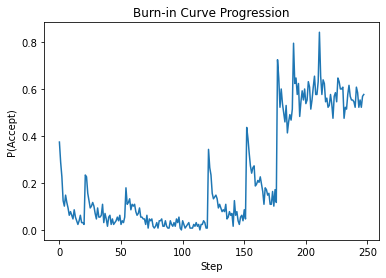

In [44]:
fig, ax = plt.subplots()

ax.plot(sampler.acceptance_fraction)

ax.set_xlabel('Step')
ax.set_ylabel('P(Accept)')
ax.set_title('Burn-in Curve Progression')

In [45]:
burn_in_length = len(sampler.acceptance_fraction)
print(f'Burn-in required {burn_in_length} steps')

Burn-in required 248 steps


In [46]:
print(sampler.acceptance_fraction[-5:])

[0.5234375 0.5546875 0.5234375 0.5703125 0.578125 ]


which is decently close to 0.5

Now running the converged sampler for 64 steps and then drawing all of the samples from the posterior

In [47]:
%%time
# Get more samples by running with the now-converged sampler
outputs = sampler.run_mcmc(64)

CPU times: user 20.1 s, sys: 79.3 ms, total: 20.2 s
Wall time: 20.1 s


In [48]:
samples = sampler.get_samples()  # Gets only the samples after burn-in
print(f'Retrieved {len(samples)} samples from the posterior')

Retrieved 4312 samples from the posterior


Now that all the samples have been retrieved, answering the following questions:

1. What is the mean and the 95% confidence intervals of $c_2$ and $\alpha_H$? Compute the confidence intervals using the 2.5 and 97.5 percentiles with numpy's percentile function.

2. Plot the mean and 95% confidence intervals (Hint: fill_between) of the heat capacity ($C_p(T)$) as a function of temperature between 2500 and 5000K.

3. Does the model consistently over- or underestimate the heat capacity at intermediate temperatures (3500-4000K)? Which data points do you think are leading to that systematic error?

In [49]:
#priors = c0, c1, c2, aCp, aH
# index for c2 and aH is 2 and 4

c2_post = samples[:,2]
aH_post = samples[:,4]

In [50]:
c2_confid_interv = (np.percentile(c2_post, 2.5),np.percentile(c2_post, 97.5))
c2_mean = np.mean(c2_post)

aH_confid_interv = (np.percentile(aH_post, 2.5),np.percentile(aH_post, 97.5))
aH_mean = np.mean(aH_post)

print(f'The mean for c_2 is {c2_mean}, and the confidence interval is {c2_confid_interv}')
print(f'The mean for a_H is {aH_mean}, and the confidence interval is {aH_confid_interv}')

The mean for c_2 is 0.0053230171546375035, and the confidence interval is (0.004780549910854795, 0.00582621198716387)
The mean for a_H is 2.6660828494315716, and the confidence interval is (1.8160827611980515, 3.6353987484603514)


In [51]:
def c_p(c_1,c_2,T):
    '''
    Computes the heat capacity given parameters
    '''
    return c_1 + c_2 * T

In [52]:
T = np.linspace(2500, 5000, 128)
Cp_predictions = [c_p(s[1],s[2],T) for s in samples]

Text(0.5, 1.0, 'Predicted $C_p$ from sampled parameters (original data shown in red)')

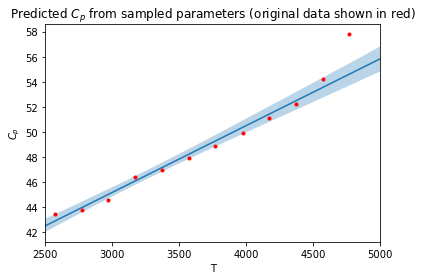

In [53]:
fig, ax = plt.subplots()

# Plot between the 2.5th and 97.5th percentiles
ax.fill_between(
    T, np.percentile(Cp_predictions, 2.5, axis=0), np.percentile(Cp_predictions, 97.5, axis=0),
    alpha=0.3
)

# Plot the mean
ax.plot(T, np.mean(Cp_predictions, axis=0))
ax.set_xlim(2500, 5000)

ax.plot(x, y, 'r.')

ax.set_xlabel('T')
ax.set_ylabel('$C_p$')
ax.set_title('Predicted $C_p$ from sampled parameters (original data shown in red)')

Notice that at the intermediate values, it seems as though the we are systematically underpredicting (unlike at the beginning where variation is quite random, which is to be expected). I beleive that this might be caused by the point near the higher values of T, whereby one or two points are 'pulling up' the model due to the high values observed at these temperature ranges.

### Problem 4: Outlier Sensitivity

Modifying the likelihood function to take the form of student-t distributions (df=2.1) rather than normal distributions, and re-running problems 2 and 3.

In [30]:
class Posterior_modif:
    """Posterior probability of liquid H thermodynamic models
    
    Assumes parameters are in the order: c_0, c_1, c_2, alpha_cp, alpha_h
    """
    
    def __init__(self, cp_data, h_data, priors):
        """Initialize the class
        
        Args:
            cp_data: Heat capacity data
            h_data: Enthalpy data
            prior: Prior distributions for each parameter
        """
        self.cp_data = cp_data
        self.h_data = h_data
        self.priors = priors
        
    def logprob_cp_data(self, params):
        """Compute the log probability of observing the C_p data
        
        Args:
            params ([float]): Chosen parameters
        Returns:
            Log-likelihood of observing the data
        """
        
        # Constructing the normal distributions t distributions for each
                
        cp_data['preds'] = params[1] + params[2] * cp_data['T']

        logpdf = stats.t.logpdf(cp_data['Cp'],2.1,cp_data['preds'],params[3]).sum()
    
        return logpdf
    
    def logprob_h_data(self, params):
        """Compute the log probability of observing the H data
        
        Args:
            params ([float]): Chosen parameters
        Returns:
            Log-likelihood of observing the data
        """
        
        h_data['preds'] = params[0] + params[1] * h_data['T'] + params[2] * h_data['T'] ** 2 / 2
        
        logpdf = stats.t.logpdf(h_data['H'],2.1, h_data['preds'],params[4]).sum()

        return logpdf
        
    def logprob_prior(self, params):
        """Compute the log probability of the parameters given the prior distributions.
        
        Includes the prior for model parameters and the "dataset weights" (\alpha)
        
        Args:
            params ([float]): Chosen parameters
        Returns:
            Log-likelihood of the priors
        """
        
        logpdf_prior = 0
        
        for prior, th in zip(priors,params):
            logpdf_prior += prior.logpdf(th)

        return logpdf_prior
    
    def __call__(self, params):
        """Compute the log posterior probability given the paramers
        
        Args:
            params ([float]): Chosen parameters
        Returns:
            Log-likelihood of the posterior
        """
        
        return self.logprob_cp_data(params) + self.logprob_prior(params) + self.logprob_h_data(params)

In [31]:
ln_posterior_p4 = Posterior_modif(cp_data, h_data, priors)
test_params = [5000, 35, 0.005, 1, 1]
print(ln_posterior_p4.logprob_cp_data(test_params))
print(ln_posterior_p4.logprob_h_data(test_params))
print(ln_posterior_p4.logprob_prior(test_params))
print(ln_posterior_p4(test_params))

-54.741155923890915
-565.9993195067407
-12.040465823988008
-632.7809412546196


Re-constructing part 3

In [32]:
sampler_p4 = kombine.Sampler(n_walkers, n_params, ln_posterior_p4, pool=kombine.serialpool.SerialPool())

In [33]:
%%time

output_p4 = sampler_p4.burnin(param_init)

CPU times: user 1min 27s, sys: 335 ms, total: 1min 27s
Wall time: 1min 27s


Text(0.5, 1.0, 'Burn-in Curve Progression')

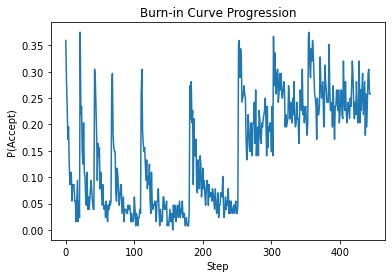

In [34]:
fig, ax = plt.subplots()

ax.plot(sampler_p4.acceptance_fraction)

ax.set_xlabel('Step')
ax.set_ylabel('P(Accept)')
ax.set_title('Burn-in Curve Progression')

In [35]:
burn_in_length = len(sampler_p4.acceptance_fraction)
print(f'Burn-in required {burn_in_length} steps')

Burn-in required 445 steps


In [36]:
print(sampler_p4.acceptance_fraction[-5:])

[0.25      0.296875  0.3046875 0.2578125 0.2578125]


In [37]:
outputs_p4 = sampler_p4.run_mcmc(64)

samples_p4 = sampler_p4.get_samples()  # Gets only the samples after burn-in
print(f'Retrieved {len(samples_p4)} samples from the posterior')

Retrieved 2802 samples from the posterior


Re-measuring the mean and confidence intervals of $c_2$ and re-plot the mean and confidence intervals of $C_p$ as a function of temperature

In [38]:
c2_post_p4 = samples_p4[:,2]

c2_confid_interv_p4 = (np.percentile(c2_post_p4, 2.5),np.percentile(c2_post_p4, 97.5))
c2_mean_p4 = np.mean(c2_post_p4)

print(f'The mean for c_2 is {c2_mean_p4}, and the confidence interval is {c2_confid_interv_p4}')

The mean for c_2 is 0.0047653183323146855, and the confidence interval is (0.004223428117108218, 0.00521234931515113)


In [39]:
T = np.linspace(2500, 5000, 128)
Cp_predictions_p4 = [c_p(s[1],s[2],T) for s in samples_p4]

Text(0.5, 1.0, 'Predicted $C_p$ from sampled parameters (original data shown in red)')

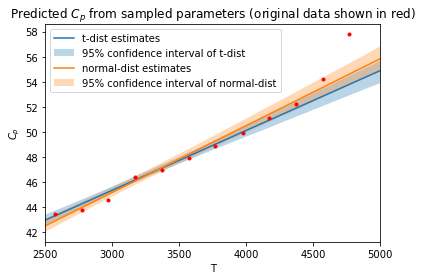

In [54]:
fig, ax = plt.subplots()


# Plot the mean
ax.plot(T, np.mean(Cp_predictions_p4, axis=0),label='t-dist estimates')
ax.set_xlim(2500, 5000)

# Plot between the 2.5th and 97.5th percentiles
ax.fill_between(
    T, np.percentile(Cp_predictions_p4, 2.5, axis=0), np.percentile(Cp_predictions_p4, 97.5, axis=0),
    alpha=0.3, label="95% confidence interval of t-dist"
)

# Plot the mean
ax.plot(T, np.mean(Cp_predictions, axis=0),label='normal-dist estimates')
ax.set_xlim(2500, 5000)

# Plot between the 2.5th and 97.5th percentiles
ax.fill_between(
    T, np.percentile(Cp_predictions, 2.5, axis=0), np.percentile(Cp_predictions, 97.5, axis=0),
    alpha=0.3, label="95% confidence interval of normal-dist"
)


ax.plot(x, y, 'r.')

ax.set_xlabel('T')
ax.set_ylabel('$C_p$')
ax.legend()
ax.set_title('Predicted $C_p$ from sampled parameters (original data shown in red)')

#### Answering: 
1. Is $c_2$ larger or smaller?
2. Does the model have the same systematic errors or are they smaller? Describe why the change has occured?

Notice that $c_2$ is smaller in this example (0.0047 point estimate in the current version and 0.0053 point estimate in the previous version).

However, it does nevertheless looks like we might be under-predicting slightly with the t-distribution model. The changes in the errors could be due to the fact that we are no longer imposing a strict normality condition, where as the t-distribution does not make the assumption that the population sample standard deviation is known, which gives the data more leeway in making predictions. 

P.S. Unfortunately the burn-in is quite time/computationally intensive (and windows system only allows for single-thread operations), and thus I was only able to run burn-ins a few times without having my computer on idle for long periods of time.